## Johnny Man, Manzi Bryan, Abubakar Kasule, Maria Roodnitsky
### Computer Science 69
### 13th Novemeber 2020

In [1]:
# This Notebook was used for the final project of CS 69. It was used to process signals captured using the BLE Hero 
# Application. 

# There were three objectives to this notebook: 
# 1. Can we determine an appropriate RSSI threshold to determine whether two devices are separated by a wall?
# 2. Can we determine an appropriate system that estimates the likelihood that two devices are within covid transmission range?
#       a. The CDC says that both length of contact, and closeness of contact are good indicators of the likelihood
#          of covid transmission. As a result, we will use a combination of [1] length of contact (measured through
#          time between measurements) and distance between the devices (measured using RSSI)
# 3. Can we leverage some networking effects to build a better model of covid transmission?

Our Approach:

# Note to self: create a top cap.
# Indoor vs outdoor
1. We will have an 'encounters' dictionary. This dictionary will have device name as it's key and a secondary dictionary as it's value. This dictionary will map to
        a.  a list of rssi values captured from that device
        b. a list of times when that rssi reading was taken
        
2. The first step will be to determine a threshold for a contact event. Maria found that this was 70  - TODO EXPLAIN WHY

3. The second step will be to estimate the risk of covid transmission. Since we think time and distance are equal contributors to the likelihood of infection, we will use the Area Under The Curve (AUC) where x = time and y = RSSI. THis makes sense, since CDC says time and distance of an encounter are the main factors in covid transmission. There are several problems with this approach.
        a. First, AUC is ill-defined if any of the parameters have negative values. We will solve this by adding +200 to all of the values in all of our rssi readings. This makes sense because we know that none of the readings will be below -200
<!--  SOME BULLSHIT       b. It is possible that you encounter someone several times in one day, but do not spend a long time with them. A good example is the staff at 53 Commons. The average student will encounter Bobby from Foco at 8AM, 2PM and 8PM. But they will have a low risk of infection, since these encounters are only seconds long. To tackle this, we will only store a device as an encounter if we had identified this device in the last dropTime=60 minutes. This way, unless your conversation with Bobby from Foco lasts dropTime=60 minutes or more we will ignore it.
         -->

ADDITION:


We are worrid that an individual might go to a party with 100 people and appear to be safe for the remainder of their day. Compared to another individual who has medium engagement with a few people. Our system would penalize the medium enaged person unfairly. As a result, we want to report dual metrics. The highest rssi 



ADDITION:

We may need to use the number of devices as a metric as well 

In [1]:
def addEncounter(connectable, time, name, rssi, encounters):
    inTrustedDevices = [name in x for x in trustedDevices]
    inTrustedDevices = True in inTrustedDevices
    if connectable and not inTrustedDevices and rssi > minRSSI and rssi < 100:
        if name in encounters:
                encounters[name]['rssi'].append(rssi)
                encounters[name]['timeElapsed'].append(time)
                
                encounters['all']['rssi'].append(rssi)
                encounters['all']['timeElapsed'].append(time)
        else:
            encounters[name] = {'rssi': [], 'timeElapsed':[]}
            encounters[name]['rssi'].append(rssi)
            encounters[name]['timeElapsed'].append(time)
            
            encounters['all']['rssi'].append(rssi)
            encounters['all']['timeElapsed'].append(time)
            

In [2]:
import time

# Returns the time elapsed 
def timeDifference(timeOfCapture):
    microSecond = int(timeOfCapture.split('.')[1])/100
    timeAsArray = [int(i.split('.')[0]) for i in timeOfCapture.split(':')]
    timeElapsed = (timeAsArray[0] * 3600 + timeAsArray[1] * 60 + timeAsArray[2])
    timeElapsed += microSecond
    return timeElapsed
    
    

In [3]:
def sortByTime(list1, sortBy):
    zipped_pairs = zip(sortBy, list1)
    z = [x for _, x in sorted(zipped_pairs)]
     
    return z

In [4]:
import ast

class Advertisement:
    def __init__(self, block, encounters):
        self.content = block.split(',')[:-1]
        self.time = timeDifference(self.content[0])
        self.connectable = self.content[1].split(':')[1].strip() == 'true'
#         self.manufacturerData = self.content[2].split(':')[1]
#         self.serviceData = self.content[4].split(':')[1]
#         self.services = self.content[5].split(':')[1]
#         self.solicitedServiceUUIDs = self.content[6].split(':')[1]
#         self.transmitPowerLevel = self.content[7].split(':')[1]
        nameTag = "Local Name: "
        nameLocation = block.find(nameTag) + len(nameTag)
        self.localName = block[nameLocation :].split(',')[0]
        
        rssiTag = "RSSI: "
        rssiLocation = block.find(rssiTag) + len(rssiTag)
        self.rssi = int(block[rssiLocation:].split(',')[0])
        addEncounter(self.connectable, self.time, self.localName, self.rssi, encounters)
        
        
    def __str__(self):
        return str(self.time + ' , ' + self.localName + ' , ' + self.rssi)
        

In [5]:
import matplotlib.pyplot as plt
# Not Being Used
def plotEncountersByDevice(encounters):
    for key in encounters:
        dev = encounters[key]
        rssi = sortByTime(dev['rssi'], dev['timeElapsed'])
        time = sorted(dev['timeElapsed'])
        if len(rssi) > 1:
            plt.legend(title='RSSI against Time', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
            plt.plot(time, rssi, label=key)

In [22]:

def plotAllEncounters(encounters, fileName):
    rssi = sortByTime(encounters['all']['rssi'], encounters['all']['timeElapsed'])
    time = sorted(encounters['all']['timeElapsed'])
    time = [x - min(time) for x in time ]
    justName = fileName.find("/") + 1
    plt.scatter(time, rssi, label = fileName[justName:-4])
    plt.legend(title='RSSI Against Time', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Time")
    plt.ylabel("RSSI")
#     plt.legend(loc="best")

In [23]:
def breakUpEncounters(encounters, window):
    
    brokenUp = []
    allRSSI = []
    # If we haven't gotten any interesting readings, just return noth
    if len(encounters['all']['rssi']) <= 1:
        return brokenUp
    
    encounters['all']['rssi'] = sortByTime(encounters['all']['rssi'], encounters['all']['timeElapsed'])
    encounters['all']['timeElapsed']

    # Goal is to return a nested list of dictionaries where each list contains a scan of length [window]
    
    allReadings = []
    oneWindow = {'rssi' : [], 'timeElapsed': []}
    i = 0
    timeElapsed = encounters['all']['timeElapsed']
    rssi = encounters['all']['rssi']
    startTime = timeElapsed[0]
    timer = timeElapsed[0]
    
    
    while i < len(timeElapsed) - 1:
        timeDifference = timeElapsed[i] - startTime
        oneWindow['rssi'].append(rssi[i])
        oneWindow['timeElapsed'].append(timeElapsed[i])
        
            
        if timeDifference > window: # If the next reading is outside of our time reading, move on to the next reading
            i += 1
            startTime = timeElapsed[i]
            allReadings.append(oneWindow)
            oneWindow = {'rssi' : [], 'timeElapsed': []}
        
        
            
            
        i += 1
   
        
#     # The above algorithm will skip the last element in the time series. The line below compensates for this. 
#     # Yes, this is janky code. Sometimes thasslife
#     timeDifferenceLastElement = timeElapsed[-1] - timeElapsed[-2]
#     if timeDifferenceLastElement < window:
#         oneWindow['rssi'].append(rssi[i])
#         oneWindow['timeElapsed'].append(timeElapsed[i])
        
#     if len(allReadings) == 0:
#         if len(oneWindow['rssi']) != 0:
#             return [oneWindow]
#         else:
#             return []
   
#     if allReadings[-1] != oneWindow:
#         allReadings.append(oneWindow)
     
    return allReadings        

In [47]:
# This function takes in a dictionary of encounters. 
# It calculates a simple risk metric by calculating the sum of the area under each curve passed into it
from numpy import trapz, percentile
global window

def calculateSimpleRisk(brokenUp):
    i = 0
    areas = []
    mins = []
    if len(brokenUp) == 0:
        return [], []
    i = 0
    previous = brokenUp[0]
    for chunk in brokenUp[1:]:
        if len(chunk["rssi"]) <= 1:
            areas.append(0)
            mins.append("N/A")
            
            continue
        rssi = chunk['rssi']
        times = chunk['timeElapsed']
        
        
        rssi = sortByTime(rssi, times)
        times = sorted(times)
        
        
        # In order to avoid a negative area, we will add a large value to all of the points. 
        # That way, the minimum y value will be 0
        shiftedRSSI = [shift + y_i for y_i in rssi]
        shiftedTimes = [t_i - times[0] for t_i in times]

        area = trapz(shiftedRSSI, times)
        currentMinimum = percentile(rssi, 50)
        
        areas.append(area)
        mins.append(currentMinimum)
        
    print(len(areas), len(mins))
    return areas, mins
    
    

In [48]:
import pickle 
from scipy import stats

def compareUser(riskDF, file):
    
    numberOfChunks, userRisks, oneRiskDF, mins = buildUserModel(riskDF, file)
    
    
    with open('popRisks.pkl', 'rb') as f:
        popRisks = pickle.load(f)
    popRisks.sort()
    
    if len(userRisks) == 0:
        userRisks = [0]
    
    for area in userRisks:
        print("this reading is in the ", round(stats.percentileofscore(popRisks, area), 2), " percentile")
    print("User Compared")
        
    

In [49]:
import pickle
global riskDF



def buildUserModel(riskDF, fileLoc):
    print(fileLoc)
    encounters = {}
    encounters['all'] = {'rssi': [], 'timeElapsed':[]}
    
    # Using readlines() 
    file = open(fileLoc, 'r') 
    lines = file.readlines() 

    # Strips the newline character 
    block = None
    for line in lines: 
        countNumOccurences(fileLoc)
        if 'Advertisement' in line: # start a new block
            block = ''
            block += line.split(' ')[0] + ','

        elif 'Adv Estimate' in line: # finish old block
            adv = Advertisement(block, encounters)

        else:
            if block != None:
                if len(line) > 1:
                    block += line.strip() + ','


    plotAllEncounters(encounters, fileLoc)
    brokenUp = breakUpEncounters(encounters, window)
    numberOfChunks = max(len(brokenUp), 1)
    areas, mins = calculateSimpleRisk(brokenUp)
    lengthOfChunks = [len(x['rssi']) for x in brokenUp]
    oneRiskDF = addToDF(riskDF, fileLoc, areas, mins)
    return numberOfChunks, areas, oneRiskDF, mins
        
        

In [50]:
def countNumOccurences(fileLoc):
    global public, shared, solitary, hallway, outside
    
    if 'Foco' in fileLoc or 'Novack' in fileLoc:
        public += 1
        
    if 'Shared' in fileLoc:
        shared += 1
        
    if 'Solitary' in fileLoc:
        solitary += 1
    
    if 'Outside' in fileLoc:
        outside += 1
    
    if 'Hallway' in fileLoc:
        hallway += 1

In [51]:
import pickle
import os


def buildPopulationModel(riskDF, allCapturesDirectory, saveTo):
    numChunksInPop = 0
    popRisks = []
    allCaptures = sorted(os.listdir(allCapturesDirectory))
    
    for fileName in allCaptures:
        if fileName.startswith('.'):
            continue
        numChunksInUser, userRisks, oneRiskDF, mins = buildUserModel(riskDF, allCapturesDirectory + '/' + fileName)
        numChunksInPop += numChunksInUser
        popRisks += userRisks
        riskDF = riskDF.append(oneRiskDF, ignore_index=True)
        
    print("In total, we had ", numChunksInPop, " series of data points ")

    with open('popRisks.pkl', 'wb') as f:
        pickle.dump(popRisks, f)
    riskDF.to_excel(saveTo)
    return riskDF

In [82]:


def addToDF(riskDF, fileName, areas, mins):
    print(len(mins), '  and ', len(areas))
    if "Foco" in fileName or "Novack" in fileName:
        indoorOutdoor = "Indoors"
        moving = "moving"
        numberOfDevices = '10+'
        avgDistance = '2 - 3 Feet'
        obstructions = 'None'
        activityType = 'Public Eating Place'
        
    elif "Hallway" in fileName:
        indoorOutdoor = "Indoors"
        moving = "moving"
        numberOfDevices = '0'
        avgDistance = '10+ Feet'
        obstructions = 'Wall'
        activityType = 'Hallway'
        
    
    elif "SharedRoom" in fileName:
        indoorOutdoor = "Indoors"
        moving = "stationary"
        numberOfDevices = '5+'
        avgDistance = '2 - 3 Feet'
        obstructions = "N/A"
        activityType = 'In Shared Room'
        
    elif "SolitaryRoom" in fileName:
        indoorOutdoor = "Indoors"
        moving = "stationary"
        numberOfDevices = '2'
        avgDistance = '15+ Feet'
        obstructions = "N/A"
        activityType = 'In Solitary Room'
        
    elif "Outside" in fileName:
        indoorOutdoor = "Outdoors"
        moving = "moving"
        numberOfDevices = '1-2'
        avgDistance = '15+ Feet'
        obstructions = "N/A" 
        activityType = 'Walking Outdoors'
    
    else:
        assert(indoorOutdoor != None)
        
    oneRiskDF = pd.DataFrame(index = range(len(areas)), columns=["Situation", "Indoor/Outdoor", "Filename", "Moving", "Number Of Devices", "Average Distance", "Obstructions", "Area", "Min"])
    i = 0
    justName = fileName.find("/") + 1
    justName = fileName[justName:-4]
    
    while i < len(areas):
        area = areas[i]
        currentMin = mins[i]
        oneRiskDF["Indoor/Outdoor"][i] = indoorOutdoor
        oneRiskDF["Filename"][i] = justName
        oneRiskDF["Moving"][i] = moving
        oneRiskDF["Number Of Devices"][i] = numberOfDevices
        oneRiskDF["Average Distance"][i] = avgDistance
        oneRiskDF["Obstructions"][i] = obstructions
        oneRiskDF["Area"][i] = area
        oneRiskDF["Situation"][i] = activityType
        oneRiskDF["Min"][i] = currentMin
        i += 1
        

    return oneRiskDF
    

test/InSharedRoom3.txt
1 1
1   and  1
test/InSharedRoom4.txt
5 5
5   and  5
test/InSharedRoom5.txt
3 3
3   and  3
test/InSharedRoom6.txt
2 2
2   and  2
test/InSharedRoom7.txt
5 5
5   and  5
test/InSharedRoom8.txt
2 2
2   and  2
test/OutsideWalk.txt
8 8
8   and  8
test/OutsideWalk2.txt
5 5
5   and  5
In total, we had  39  series of data points 
0 6589 0 0 4912


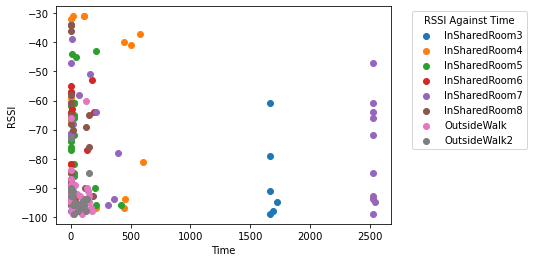

In [86]:
import pandas as pd
global window, public, shared, solitary, hallway, outside

if __name__ =='__main__':
    shift = 200
    secPerMin = 60
    minRSSI = -100
    allCapturesDirectory = 'test'
    window = 4/60 * secPerMin
    trustedDevices = ['Manzi’s MacBook Pro', 'LE_SRS-XB32']
    saveTo = 'riskDocument.xlsx'
    public = 0
    shared = 0
    solitary = 0
    hallway = 0
    outside = 0
    """
        For risk estimation, we will divide all of the collected data from one person into 1 minute windows.
        We will then create a risk metric by comparing these minutes
    """
    
    riskDF = pd.DataFrame(columns=["Indoor/Outdoor", "Filename","Moving", "Number Of Devices", "Average Distance", "Obstructions"])
    riskDF = buildPopulationModel(riskDF, allCapturesDirectory, saveTo)
    
    
    df = pd.read_excel('riskDocument.xlsx')
#     compareUser(df, 'test/InSolitaryRoom7.txt')
    print(public, shared, solitary, hallway, outside)
#     compareUser("captures/AtFoco.txt")


In [87]:
# In Shared Room 4: 3 laptops, 2 phones, 2 headphones, 1 speaker in dorm


In [88]:
import pandas as pd
import math

if __name__ == '__main__':
    target = 'Situation'
    tableDoc = 'riskDocument.xlsx'
    table = pd.read_excel(tableDoc)
    
    
    situations = table[target].unique()
    
    columns = ["Situation", "Average AUC", "Standard Deviation of AUC", "Count", "Min RSSI"]
    smallerTable = pd.DataFrame(index = range(len(situations)), columns = columns)

    i = 0
    
    for situation in situations:
        smallerTable['Average AUC'][i] = round((table[table[target] == situation]['Area'].mean() + 0.01), 1)
        smallerTable['Standard Deviation of AUC'][i] = round(table[table[target] == situation]['Area'].std(), 1)
        smallerTable['Count'][i] = len(table[table[target] == situation])
        smallerTable['Min RSSI'][i] = min(table[table[target] == situation]['Min'])
        i+=1
    smallerTable[target] = situations
    print(list(smallerTable['Average AUC']))
    print(list(smallerTable['Situation']))

    smallerTable = smallerTable.reset_index(drop = True)
    print(smallerTable)
    smallerTable.to_excel("smallerRiskDocument.xlsx")
    

[595.3, 565.4]
['In Shared Room', 'Walking Outdoors']
          Situation Average AUC Standard Deviation of AUC Count Min RSSI
0    In Shared Room       595.3                    1361.1    18      -97
1  Walking Outdoors       565.4                    1007.9    13      -98
